In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from agent_replay import AgentPOMDP
from environment import Environment
from utils import plot_maze, plot_need, load_env, plot_env
import scipy
np.random.seed(2)

In [2]:
env            = 'tolman1234'
env_file_path  = os.path.abspath(os.path.join(sys.path[0], '../../code/mazes/' + env + '.txt'))
env_config     = load_env(env_file_path)

# --- Specify agent parameters ---
pag_config = {
    'alpha': 1,
    'beta':  2, 
    'gamma': 0.9,
}

ag_config = {
    'alpha_r'        : 1,         # offline learning rate
    'horizon'        : 10,        # planning horizon (minus 1)
    'xi'             : 0.0001,    # EVB replay threshold
    'num_sims'       : 2000,      # number of MC simulations for need
    'sequences'      : False,      
    'env_name'       : env,       # gridworld name
    'barriers'       : [1, 1, 1, 1]
}

agent = AgentPOMDP(*[pag_config, ag_config, env_config])

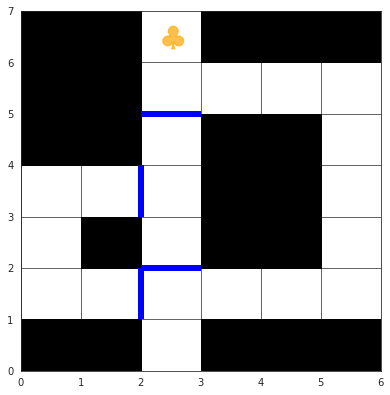

In [3]:
fig   = plt.figure(figsize=(5, 5))
ax    = fig.add_axes([0, 0, 1, 1])
plot_env(ax, agent)

In [4]:
Q_MB  = agent._solve_mb(1e-5, barriers=[1, 1, 1, 1])

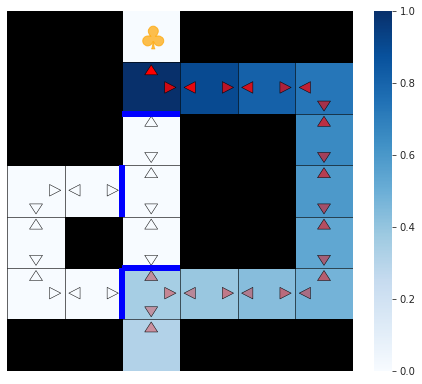

In [5]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, Q_MB, agent)

### Example replays

In [ ]:
agent.state = 38 # start state
agent.M     = np.array([[1, 0], [1, 0], [1, 0]]) # prior belief indicating the barrier is open
agent.Q     = Q_MB.copy() # initialise MF Q values
Q_history, gain_history, need_history = agent._replay() # start replay

In [ ]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, agent.Q, agent)
# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/paper_figures/fig2/replay_explore.pdf', transparent=True)

In [ ]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, agent.Q - Q_MB, agent)
# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/replay/examples/tolman123/2/replay_explore_diff.pdf', transparent=True)

In [ ]:
Q              = agent.Q.copy()
Q_before       = Q.copy()
Q_after        = Q.copy()
Q_after[14, 0] = 0.0
agent.Q        = Q_after.copy()

In [ ]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, agent.Q, agent)
# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/replay/examples/tolman123/2/online.pdf', transparent=True)

In [ ]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, agent.Q - Q_before, agent)
# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/replay/examples/tolman123/2/online_diff.pdf', transparent=True)

In [ ]:
Q_before    = agent.Q.copy()

In [ ]:
agent.state = 14
agent.M     = np.array([[0, 1], [1, 0], [1, 0]])
Q_history, gain_history, need_history = agent._replay()

In [ ]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, agent.Q, agent)
# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/replay/examples/tolman123/2/replay_negative.pdf', transparent=True)

In [ ]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, agent.Q - Q_before, agent)
# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/replay/examples/tolman123/2/replay_negative_diff.pdf', transparent=True)

### Exploration probability

In [ ]:
np.random.seed(0)

agent.state  = 38 # start state
M_range      = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
qs           = []

for M in M_range:
    agent.Q  = Q_MB.copy()
    agent.M  = M
    
    _, _, _  = agent._replay()
    
    Q_after  = agent.Q.copy()
    
    qs      += [Q_after[14, :].copy(), Q_after[20, :].copy(), Q_after[26, :].copy(), Q_after[32, :].copy()]

In [ ]:
betas = [1, 5, 10, 20]
for beta in betas:

    agent.online_beta = beta
    probs = np.zeros(len(M_range))
    for i in range(0, len(qs), 4):
        probs[i//4] = agent._policy(qs[i])[0]*agent._policy(qs[i+1])[0]*agent._policy(qs[i+2])[0]*agent._policy(qs[i+3])[0]
    plt.plot(np.array(M_range), probs, label=r'$\beta=%u$'%beta)

probs = np.zeros(len(M_range))
for i in range(0, len(qs), 4):
    probs[i//4] = (qs[i][0] == np.nanmax(qs[i]))*(qs[i+1][0] == np.nanmax(qs[i+1]))*(qs[i+2][0] == np.nanmax(qs[i+2]))*(qs[i+3][0] == np.nanmax(qs[i+3]))
plt.plot(np.array(M_range), probs, label='greedy')

plt.ylim(-0.05, 1.05)
plt.xlim(0, 1)
# plt.xticks(np.linspace(0, 1, 11), np.linspace(0, 1, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Belief', fontsize=14)
plt.ylabel('Exploration probability', fontsize=14)
plt.legend(prop={'size':12})
# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/rldm_poster/tolman1/explore_proba.svg', transparent=True)

In [ ]:
x = np.linspace(0, 1, 100)
plt.plot(x, scipy.stats.beta.pdf(x, 7, 2))
plt.xlabel('P(open)', fontsize=14)
plt.ylabel('PDF', fontsize=14)
plt.vlines(7/9, ymin=0, ymax=scipy.stats.beta.pdf(7/9, 7, 2), color='r', label=r'$\mathbb{E}[P(open)]$')
plt.legend(prop={'size':14})
plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/paper/figures/belief.svg', transparent=True)